In [1]:
# importing of libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# choosing color palette
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

## 1. Data Cleaning

In [2]:
# loading data into pandas dataframe and exploring columns and first rows
survey = pd.read_csv('survey.csv')
survey.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [3]:
# renaming columns to have all lowercase
survey.columns = [col.lower() for col in survey.columns]

# looking at dtypes, we can see all of them are pandas objects except for age that is int.
print(survey.dtypes)

timestamp                    object
age                           int64
gender                       object
country                      object
state                        object
self_employed                object
family_history               object
treatment                    object
work_interfere               object
no_employees                 object
remote_work                  object
tech_company                 object
benefits                     object
care_options                 object
wellness_program             object
seek_help                    object
anonymity                    object
leave                        object
mental_health_consequence    object
phys_health_consequence      object
coworkers                    object
supervisor                   object
mental_health_interview      object
phys_health_interview        object
mental_vs_physical           object
obs_consequence              object
comments                     object
dtype: object


In [4]:
survey.drop(['timestamp', 'state', 'comments', 'country'], axis= 1, inplace= True)

In [5]:
# there are some invalid responses in the age column ('such as 99999999 and -1729')
# include 'valid' numbers for age
survey['age'] = survey['age'].apply(lambda x: x if 0 < x < 100 else np.nan)

In [6]:
# gender is one big mess of data.
# first lower case and strip eveything to decrease options
survey['gender'] = survey['gender'].apply(lambda x: x.lower().strip())

# based on the replies, made these lists manually
male = ['male', 'm', 'make', 'cis male', 'man', 'cis man', 'msle', 'malr', 'mail', 'maile', 'something kinda male?', 'ostensibly male, unsure what that really means', 'male-ish', 'guy (-ish) ^_^', 'mal', 'male (cis)']
female = ['female', 'f', 'woman', 'female (cis)', 'cis-female/femme', 'femake', 'cis female', 'femail']

def regender(gender_input):
    
    """
    Input: a string about gender
    Output: male, female or other depending on our dictionary
    
    """ 
    if gender_input in male:
        return 'male'
    elif gender_input in female:
        return 'female'
    else:
        return 'other'
    
survey['gender'] = survey['gender'].apply(regender)

# check our final results
survey.gender.value_counts(dropna= False)

gender
male      994
female    247
other      18
Name: count, dtype: int64

In [7]:
# checking for nans
nan_cols = []
for col in survey.columns:
    if survey[col].isnull().sum():
        print(col + ' (%): ' + str(sum(survey[col].isnull())/len(survey)))
        nan_cols += [col]

# nans are present in the self-employed column and in the work_interfere column.
# at most there are 20% of values with nans so we'll replace with 'Don't know'
for col in nan_cols:
    survey[col].fillna("Don't know", inplace= True)

# i'm just gonna drop the rows without age.
survey = survey[survey.age != "Don't know"]

# in the context of our questions we need to drop everyone who is self-employed
print(survey['self_employed'].value_counts())
survey.loc[survey['self_employed'] == 'Yes'] = np.nan
survey.dropna(inplace=True)

age (%): 0.003971405877680699
self_employed (%): 0.014297061159650517
work_interfere (%): 0.2096902303415409
self_employed
No            1092
Yes            144
Don't know      18
Name: count, dtype: int64


In [8]:
# getting unique answers for every column
exclude = ['age']
possible_answers = {col:[i for i in survey[col].unique()] for col in survey.columns if col not in exclude}
possible_answers

{'gender': ['female', 'male', 'other'],
 'self_employed': ["Don't know", 'No'],
 'family_history': ['No', 'Yes'],
 'treatment': ['Yes', 'No'],
 'work_interfere': ['Often', 'Rarely', 'Never', 'Sometimes', "Don't know"],
 'no_employees': ['6-25',
  'More than 1000',
  '26-100',
  '100-500',
  '1-5',
  '500-1000'],
 'remote_work': ['No', 'Yes'],
 'tech_company': ['Yes', 'No'],
 'benefits': ['Yes', "Don't know", 'No'],
 'care_options': ['Not sure', 'No', 'Yes'],
 'wellness_program': ['No', "Don't know", 'Yes'],
 'seek_help': ['Yes', "Don't know", 'No'],
 'anonymity': ['Yes', "Don't know", 'No'],
 'leave': ['Somewhat easy',
  "Don't know",
  'Somewhat difficult',
  'Very difficult',
  'Very easy'],
 'mental_health_consequence': ['No', 'Maybe', 'Yes'],
 'phys_health_consequence': ['No', 'Yes', 'Maybe'],
 'coworkers': ['Some of them', 'No', 'Yes'],
 'supervisor': ['Yes', 'No', 'Some of them'],
 'mental_health_interview': ['No', 'Yes', 'Maybe'],
 'phys_health_interview': ['Maybe', 'No', 'Yes']

In [9]:
def replace_uncertainty(survey_answer):
    """
    Uniformizes all uncertain answers.
    Input: half-answer (string)
    Output: 'Don't know'
    
    """
    
    uncertainty = ['Maybe', 'Some of them', 'Not sure']
    if survey_answer in uncertainty:
        return "Don't know"
    else:
        return survey_answer

# apply function to all columns
for col in survey.columns:
    survey[col] = survey[col].apply(replace_uncertainty)

- **the column 'care_options' asks the question: "Do you know the options for mental health care your employer provides?" and about 30% of the answers are 'Dont know'.** 
- **in my opinion: if the answer to a question 'Do you know?' is 'I don't know' - then the answer is No.**

In [10]:
survey['care_options'] = survey['care_options'].replace(to_replace="Don't know", value= 'No')
survey['care_options'].value_counts()

care_options
No     730
Yes    380
Name: count, dtype: int64

## 2. Exploratory Data Analysis

**I was trying to come up with a question to ask the data but I wasn't feeling very creative.**
**Anywayyyy, follow me**
- **Important notes:**
- All the half answers go in the middle (0)

 **1. How does age correlate with mental health treatment?** 

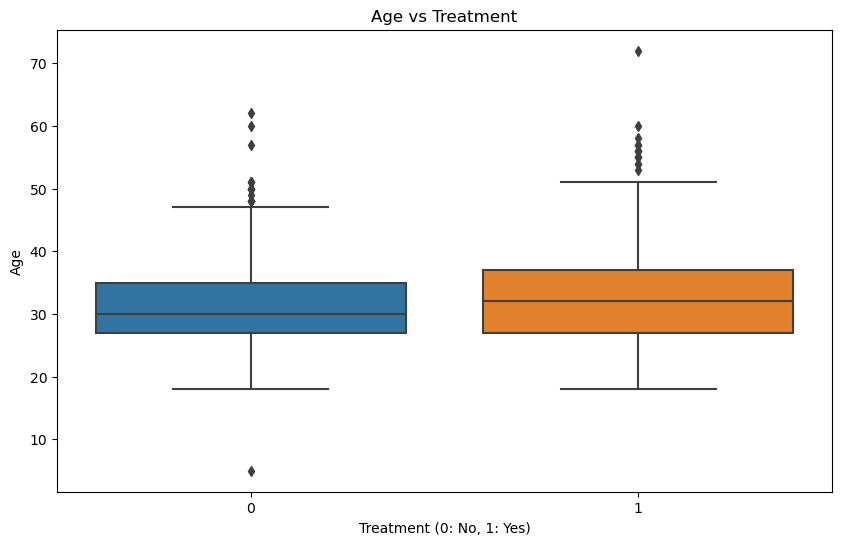

In [12]:
# Convert treatment column to binary (e.g., 'Yes' = 1, 'No' = 0)
survey['treatment_binary'] = survey['treatment'].apply(lambda x: 1 if x == 'Yes' else 0)
# Plot the correlation between age and treatment
plt.figure(figsize=(10,6))
sns.boxplot(x='treatment_binary', y='age', data=survey)
plt.title('Age vs Treatment')
plt.xlabel('Treatment (0: No, 1: Yes)')
plt.ylabel('Age')
plt.show()

In [25]:
# Descriptive stats for age by treatment group
survey.groupby('treatment_binary')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment_binary,,,,,,,,
0,553.0,31.273056,6.830209,5.0,27.0,30.0,35.0,62.0
1,557.0,32.445242,7.608162,18.0,27.0,32.0,37.0,72.0


From the box plot showing age distributions for those who sought treatment (treatment_binary = 1) 
and those who didn’t (treatment_binary = 0), we notice that:
The median age of those who received treatment is slightly higher than those who didn’t.
The interquartile range (middle 50% of ages) for both groups overlaps, but the treated group has more younger participants.
A few outliers (possibly unrealistic ages like < 15 or > 80) may skew the extremes, 
so trimming those for better accuracy might help.
Insight: Younger employees appear slightly more likely to report receiving treatment,
suggesting younger workers may be more aware of or willing to address mental health challenges.

**2. Is there a gender disparity in mental health treatment or self-reported mental health issues?**

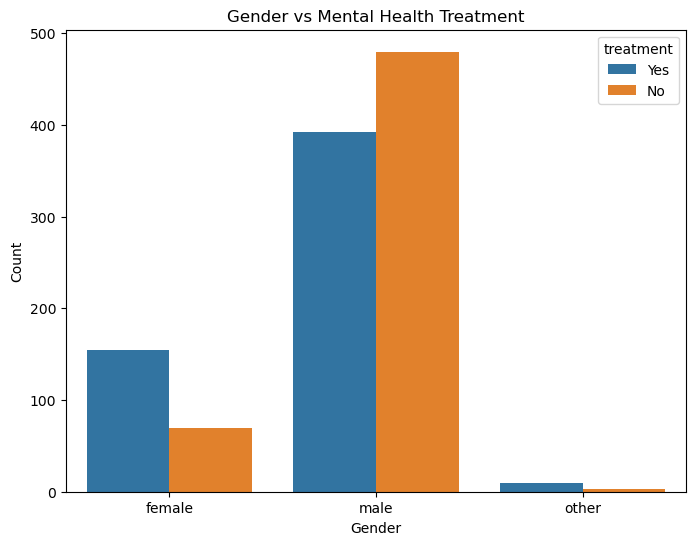

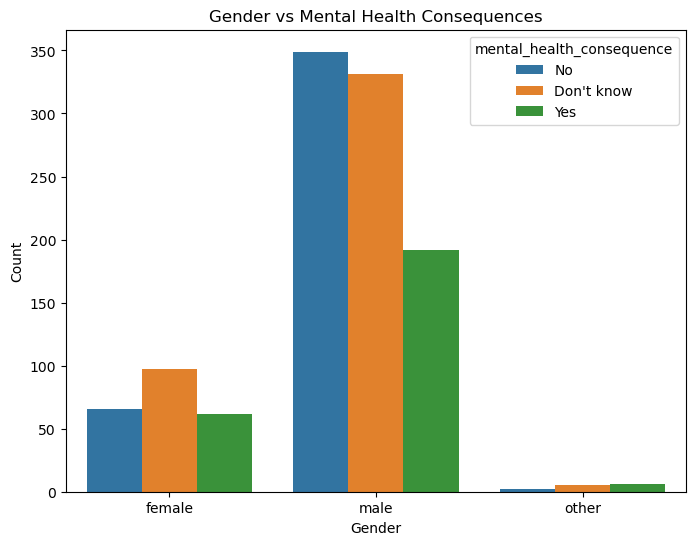

In [13]:
# Gender vs Treatment
plt.figure(figsize=(8,6))
sns.countplot(x='gender', hue='treatment', data=survey)
plt.title('Gender vs Mental Health Treatment')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Gender vs Mental Health Issues
plt.figure(figsize=(8,6))
sns.countplot(x='gender', hue='mental_health_consequence', data=survey)
plt.title('Gender vs Mental Health Consequences')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


Among females, more respondents reported seeking treatment than not,Among males, more reported not receiving treatment than receiving it.
For other gender identities, the majority also reported receiving treatment.
Also,Females mostly selected “Don’t know”, suggesting some uncertainty or lack of clarity around workplace mental health impact.
Males predominantly reported “No”, implying they did not experience workplace mental health consequences.
Others mostly reported “Yes”, indicating they felt workplace mental health consequences.
**Insight:**
Females and other gender groups may be more proactive or open in addressing mental health,
possibly due to increased awareness or differing cultural pressures.
Males appear less likely to seek treatment and may underreport mental health issues, 
possibly reflecting societal stigma or reluctance.

**3. Does remote work influence mental health outcomes in tech?**

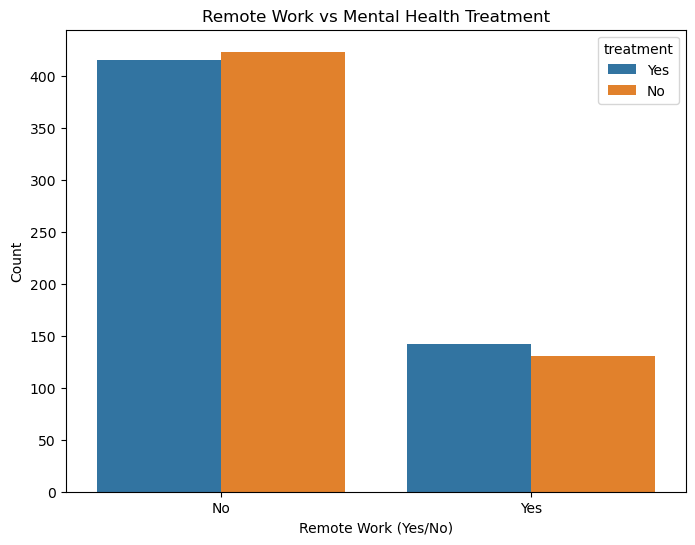

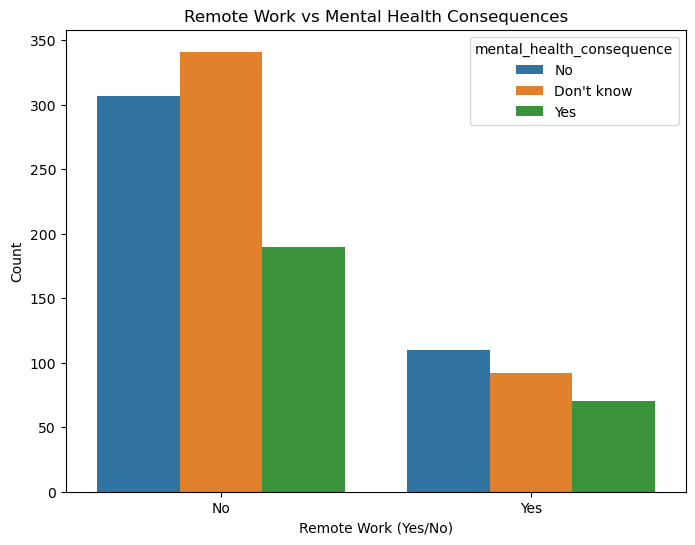

In [18]:
# Remote Work vs Treatment
plt.figure(figsize=(8,6))
sns.countplot(x='remote_work', hue='treatment', data=survey)
plt.title('Remote Work vs Mental Health Treatment')
plt.xlabel('Remote Work (Yes/No)')
plt.ylabel('Count')
plt.show()

# Remote Work vs Mental Health Consequences
plt.figure(figsize=(8,6))
sns.countplot(x='remote_work', hue='mental_health_consequence', data=survey)
plt.title('Remote Work vs Mental Health Consequences')
plt.xlabel('Remote Work (Yes/No)')
plt.ylabel('Count')
plt.show()


A larger number of remote workers reported seeking treatment than not 
For non-remote workers, more reported not seeking treatment only slightly higher than those who do.
**Insight:**
Remote workers might be more aware of or willing to address mental health challenges,possibly due to isolation or flexible schedules that allow seeking help.
In-office workers may experience barriers like workplace stigma or lack of time to access treatment.

**4.How do company benefits and wellness programs affect mental health?**

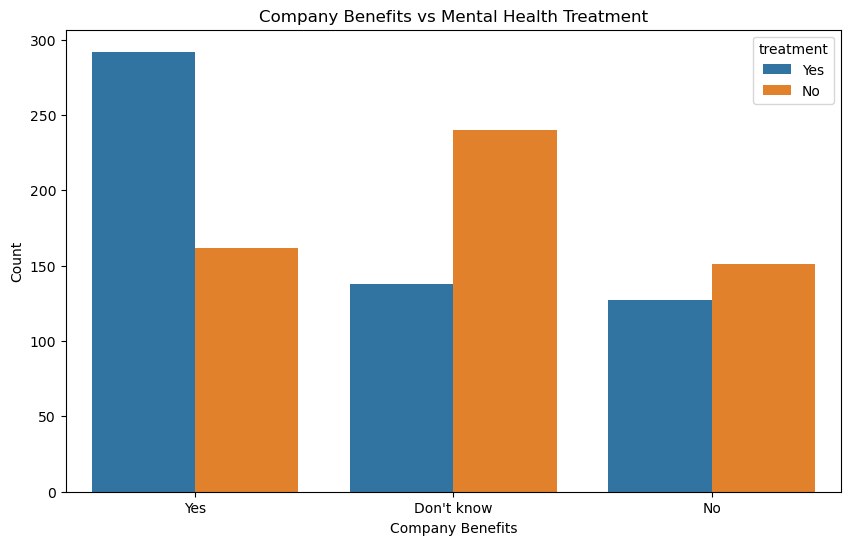

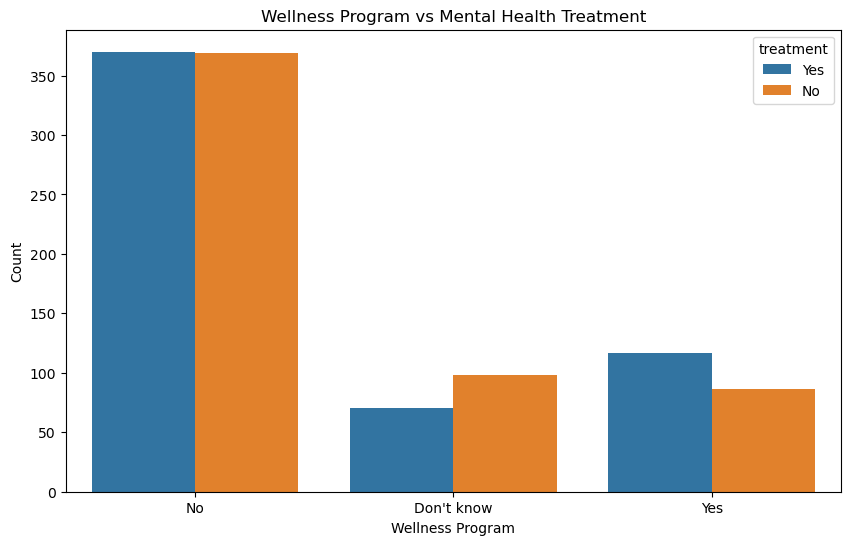

In [19]:
# Benefits vs Treatment
plt.figure(figsize=(10,6))
sns.countplot(x='benefits', hue='treatment', data=survey)
plt.title('Company Benefits vs Mental Health Treatment')
plt.xlabel('Company Benefits')
plt.ylabel('Count')
plt.show()

# Wellness Program vs Treatment
plt.figure(figsize=(10,6))
sns.countplot(x='wellness_program', hue='treatment', data=survey)
plt.title('Wellness Program vs Mental Health Treatment')
plt.xlabel('Wellness Program')
plt.ylabel('Count')
plt.show()


Respondents with access to benefits or programs are more likely to have sought treatment.
Those who don't know about access reported less treatment.
Those with no access also reported less treatment, though the margin was smaller than expected.
**Insight:**
Awareness and availability of mental health benefits appear to positively correlate with seeking help.
Lack of access or uncertainty may discourage individuals from addressing their mental health needs.

**5. Does company size (number of employees) affect mental health perception?**

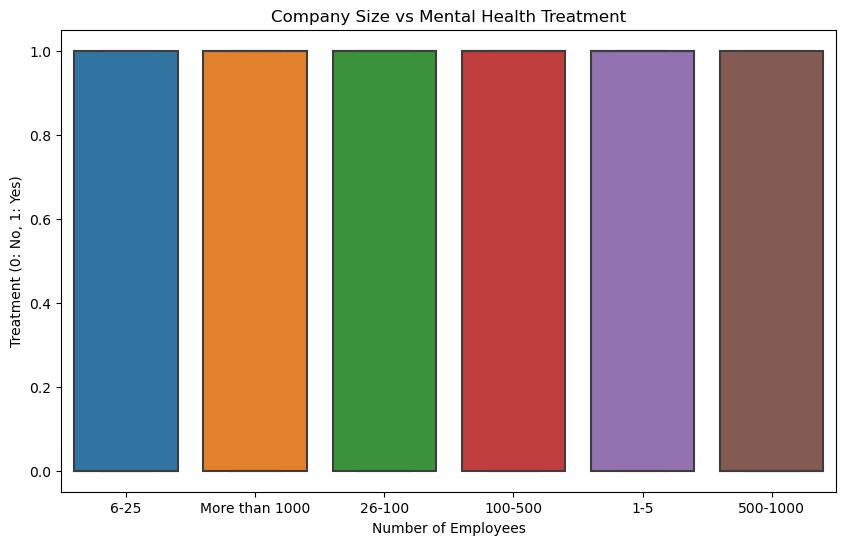

In [20]:
# Number of employees vs Mental Health Treatment
plt.figure(figsize=(10,6))
sns.boxplot(x='no_employees', y='treatment_binary', data=survey)
plt.title('Company Size vs Mental Health Treatment')
plt.xlabel('Number of Employees')
plt.ylabel('Treatment (0: No, 1: Yes)')
plt.show()


All bars are relatively equal in height, indicating no strong difference across company sizes.
**Insight:**
Company size (small, medium, or large) does not significantly influence how employees perceive mental health consequences.
Organizational culture may matter more than size alone.



**6. How does the presence of family history of mental health issues influence an employee's well-being at work?**

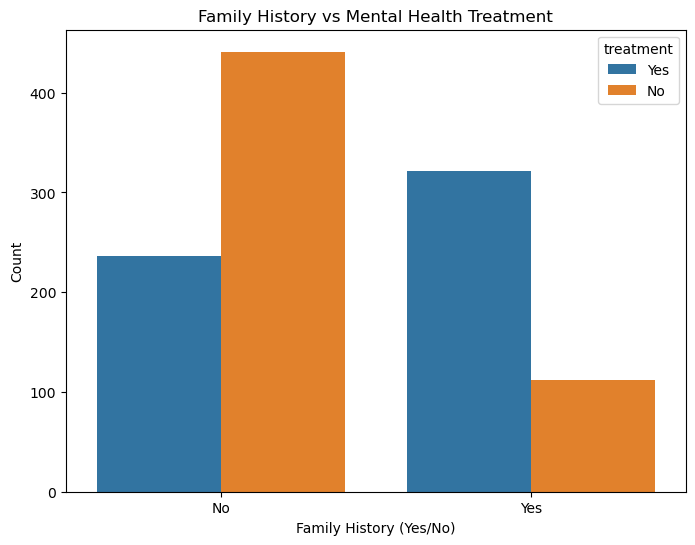

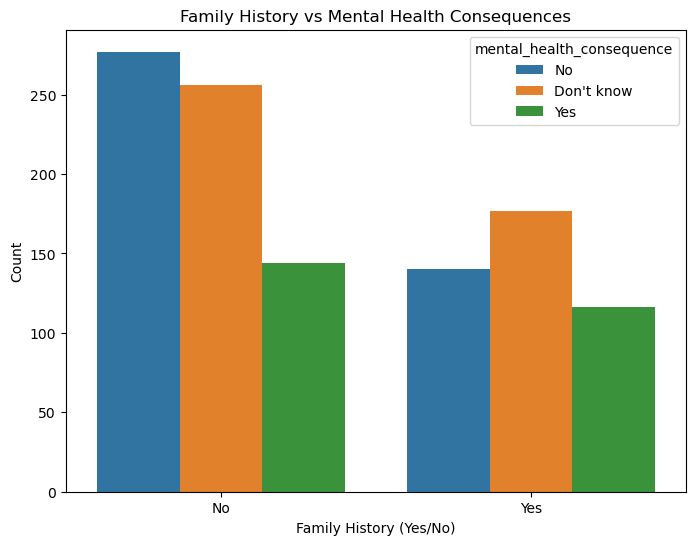

In [21]:
# Family History vs Treatment
plt.figure(figsize=(8,6))
sns.countplot(x='family_history', hue='treatment', data=survey)
plt.title('Family History vs Mental Health Treatment')
plt.xlabel('Family History (Yes/No)')
plt.ylabel('Count')
plt.show()

# Family History vs Mental Health Consequences
plt.figure(figsize=(8,6))
sns.countplot(x='family_history', hue='mental_health_consequence', data=survey)
plt.title('Family History vs Mental Health Consequences')
plt.xlabel('Family History (Yes/No)')
plt.ylabel('Count')
plt.show()


Those with family history are more likely to seek treatment.
They also selected “Don’t know” more often when asked about workplace consequences, which may reflect complex awareness or hesitance.
Those without family history are less likely to report treatment or issues.
**Insight:**
Personal or familial experience might increase awareness and sensitivity to mental health needs, encouraging action.
However, uncertainty remains about workplace impact, even among those affected.

**7. What factors are associated with individuals seeking help for mental health issues?**

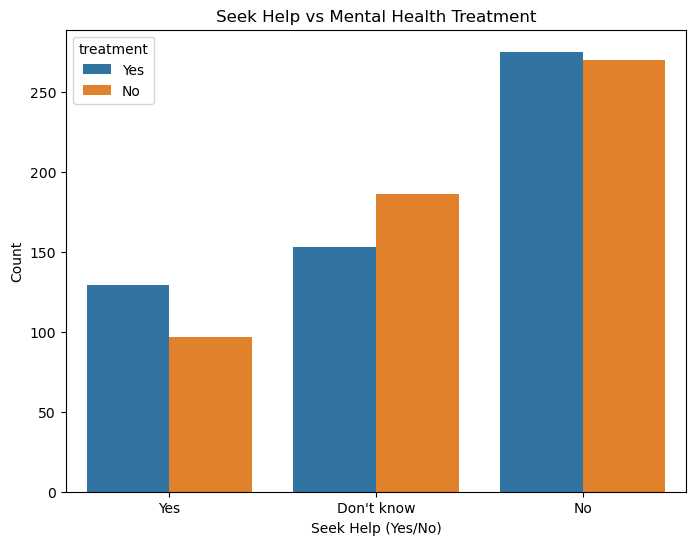

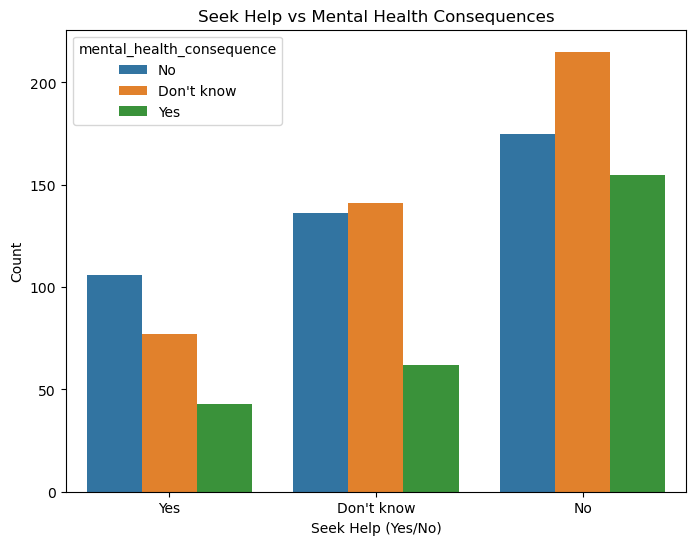

In [22]:
# Seek Help vs Treatment
plt.figure(figsize=(8,6))
sns.countplot(x='seek_help', hue='treatment', data=survey)
plt.title('Seek Help vs Mental Health Treatment')
plt.xlabel('Seek Help (Yes/No)')
plt.ylabel('Count')
plt.show()

# Seek Help vs Mental Health Consequences
plt.figure(figsize=(8,6))
sns.countplot(x='seek_help', hue='mental_health_consequence', data=survey)
plt.title('Seek Help vs Mental Health Consequences')
plt.xlabel('Seek Help (Yes/No)')
plt.ylabel('Count')
plt.show()


More people who reported interference or performance issues also reported receiving treatment.
Surprisingly, many who said they had no consequences still reported seeking treatment.
**Insight:**
Treatment might not be reactive to workplace problems only — some employees seek help proactively.
Benefits availability strongly influences treatment-seeking behavior, regardless of current work impact.

**8. Does the willingness of coworkers and supervisors to discuss mental health affect employee well-being?**

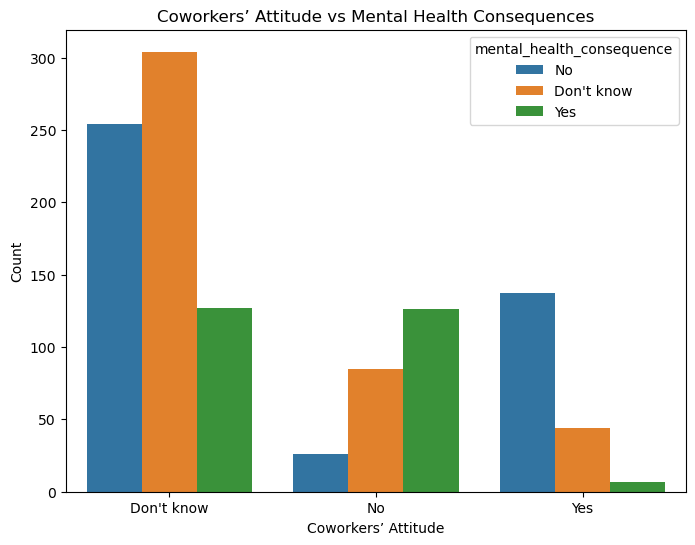

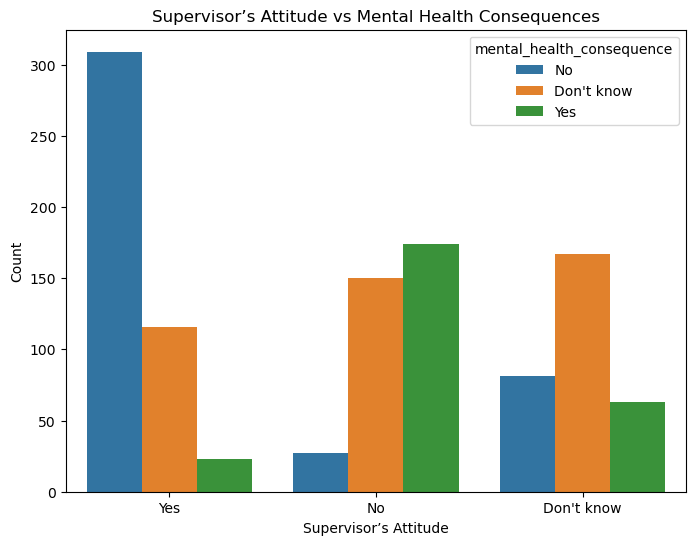

In [23]:
# Coworkers vs Mental Health Consequences
plt.figure(figsize=(8,6))
sns.countplot(x='coworkers', hue='mental_health_consequence', data=survey)
plt.title('Coworkers’ Attitude vs Mental Health Consequences')
plt.xlabel('Coworkers’ Attitude')
plt.ylabel('Count')
plt.show()

# Supervisor vs Mental Health Consequences
plt.figure(figsize=(8,6))
sns.countplot(x='supervisor', hue='mental_health_consequence', data=survey)
plt.title('Supervisor’s Attitude vs Mental Health Consequences')
plt.xlabel('Supervisor’s Attitude')
plt.ylabel('Count')
plt.show()


Open supervisors slightly reduce reported consequences and increase treatment-seeking.
Coworker openness does not significantly change treatment or outcomes.
**Insight:**
Supervisor openness and leadership culture have greater influence on employee well-being than peer-level interactions.
Supportive management might encourage employees to take mental health seriously and act early.